<a href="https://colab.research.google.com/github/VielF/ColabProjects/blob/main/Segmenta%C3%A7%C3%A3o_por_Crescimento_de_Regi%C3%B5es_Parte_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Universidade do Vale do Itajaí<br>
Escola Politécnica<br>
Processamento Digital de Imagens

# Exercício Segmentação Clássica - Sem Deep Learning

### Tutoriais da OpenCV

- https://docs.opencv.org/master/d9/df8/tutorial_root.html
- https://www.geeksforgeeks.org/opencv-python-tutorial/

# Segmentação por Crescimento de Regiões - Parte 1

O sonho de consumo de todo aquele que desenvolve métodos de processamento de imagens é um algoritmo genérico para dividir a imagem em seus componentes. Para conseguir fazer isso, os algoritmos clássicos de segmentação baseiam-se em informação de semelhança entre os pixels e de continuidade de valores de pixels dentro da imagem (veja a minha digressão sobre *apriorismos Kantianos* na vídeoaula inicial onde eu apresento os domínios e as etapas da visão computacional), sendo provavelmente os algoritmos que de forma mais icônica incorporam o conceito de "domínio do espaço".

Infelizmente nenhum dos algoritmos clássicos de segmentação realiza esse sonho de consumo: um algoritmo clássico que se baseia unicamente na informação contida dentro da imagem necessariamente é um algoritmo que usa apenas informação de natureza *sintática*. Toda a informação que está à disposição do algoritmo de segmentação diz respeito apenas à própria natureza da *estrutura* (sintaxe) dos pixels: seus valores, suas posições relativas uns aos outros e seus padrões de variação no espaço. Como nenhum desses algoritmos incorpora a informação *semântica*, do significado de padrões de variação e organização, todos eles necessariamente vão dividir a imagem em regiões "parecidas", ignorando o fato de que um carro vermelho possui pneus pretos e faróis e para-choque prateados… Durante 50 anos da história da visão computacional, o pesadelo recorrente do desenvolvedor de algoritmos de interpretação de imagens foi o de juntar estes segmentos contendo paralama, capô, pneu, calota, para-choque, etc para formar uma imagem de um "automóvel". Na visão clássica isso só é possível de se fazer possuindo-se um *modelo* de qual é a aparência desse "automóvel". Essa informação, de caráter semântico, em muito extrapola o que um algoritmo de segmentação consegue fazer.

Tentativas de resolver esse problema através de um pós-processamento utilizando-se técnicas da Inteligência Artificial Simbólica Clássica Baseada em Modelos (*Model Based Reasoning*) fracassaram para todos os domínios de aplicação que fugiam do trivialmente simples. A visão computacional só conseguiu vencer essa barreira com o advento da Segmentação Semântica utilizando Redes Neurais de Aprendizado Profundo nos últimos anos. Vamos ver isso quando chegarmos nesse capítulo. Por enquanto, divirta-se com os algoritmos clássicos que foram o estado da arte durante quase 50 anos da história da visão computacional…


### Inicialização

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## K-Means

O algoritmo tradicional de análise de cluster aplicado à segmentação de imagens: pixels semelhantes que estão em regiões vizinhas são agrupados em regiões.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, interactive, interact_manual
from skimage.data import astronaut
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
import cv2

image = cv2.imread("/content/dataSeg/ct-02.jpg", cv2.IMREAD_GRAYSCALE)
#image = img_as_float(img[::2, ::2])

# Este é uma variação do clássico algoritmo k-Means chamado SLIC. Leia sobre a diferença em
# https://core.ac.uk/reader/95407090
def my_k_means(n_segments, compactness, sigma, colormap):
    global image
    colormap = eval('plt.cm.' + colormap)
    segments_slic = slic(image, n_segments=n_segments, compactness=compactness, sigma=sigma)

    fig, ax = plt.subplots(ncols=2, figsize=(15, 7), sharex=True, sharey=True)

    ax[0].imshow(mark_boundaries(image, segments_slic))
    ax[0].set_title('Original com limites: SLIC (k-Means)')

    ax[1].imshow(segments_slic, cmap=colormap, interpolation='nearest')
    ax[1].set_title('Segmentos: SLIC (k-Means)')

    for a in ax:
        a.set_axis_off()


    plt.tight_layout()
    plt.show()

interactive(my_k_means, n_segments=(5, 100), compactness=(0.1, 1.0), sigma=(0.1, 3.0), colormap = ['nipy_spectral', 'hot', 'magma', 'seismic'])

interactive(children=(IntSlider(value=52, description='n_segments', min=5), FloatSlider(value=0.55, descriptio…

## Watershed

O Watershed (divisor de águas ou, em uma tradução literal, bacia hidrográfica) é um algoritmo clássico utilizado para segmentação, ou seja, para separar diferentes objetos em uma imagem.

A partir de marcadores definidos pelo usuário, o algoritmo Watershed trata os valores dos pixels como uma topografia local (elevação). O algoritmo inunda bacias a partir dos marcadores, até que bacias atribuídas a diferentes marcadores se encontrem nas linhas watershed. Em muitos casos, os marcadores são escolhidos como mínimos locais da imagem, a partir dos quais as bacias são inundadas. Uma boa explicação da Transformada Watersher é fornecida na página do Centro de Morfologia Matemática do o laboratório de processamento de imagens do MINES ParisTech: http://www.cmm.mines-paristech.fr/~beucher/wtshed.html. Theanimation below is from there:

![](http://www.cmm.mines-paristech.fr/~beucher/lpe1.gif)

### Implementação do Watershed com SciKit

No exemplo abaixo, dois círculos sobrepostos devem ser separados. Para fazer isso, calcula-se uma imagem que é a distância ao fundo. Os máximos desta distância (ou seja, os mínimos do oposto da distância) são escolhidos como marcadores, e a inundação das bacias a partir de tais marcadores separa os dois círculos ao longo de uma linha divisória.

In [5]:
import numpy as np
from ipywidgets import interact, interactive, interact_manual
import cv2, scipy
from skimage import data
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.feature import canny
from skimage.segmentation import mark_boundaries
from matplotlib import pyplot as plt
from scipy import ndimage as ndi

from skimage.segmentation import felzenszwalb, slic, quickshift, watershed

#from skimage.morphology import watershed
from skimage.feature import peak_local_max


image = cv2.imread("/content/dataSeg/ct-02.jpg", cv2.IMREAD_GRAYSCALE)
# shifted = cv2.pyrMeanShiftFiltering(image, 21, 51)

gradient_methods = [
    'None',
    'Sobel',
    'Canny'
]

def my_watershed(gradient_method, markers, colormap):
    global image
    colormap = eval('plt.cm.' + colormap)

    if (gradient_method == 'None'):
        input_image = image
    elif (gradient_method == 'Sobel'):
        input_image = sobel(image)
    else:
        input_image = canny(image)

    # Gera os marcadores como máximos locais da distância ao fundo
    # Aplica transformação de distância euclidiana exata
    distance = ndi.distance_transform_edt(image)
    # A função peak_local_max retorna as coordenadas dos picos locais (máximos) em uma imagem.
    # Um filtro máximo é usado para encontrar máximos locais. Esta operação dilata o original
    # imagem e mescla máximos locais vizinhos mais próximos do que o tamanho da dilatação.
    # Coordenadas onde a imagem original é igual à imagem dilatada são retornadas como máximos locais.
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((8,8)), labels=image, min_distance=20)
    # Pegue o número...
    #markers = ndi.label(local_maxi)[0]
    #labels = watershed(-distance, markers, mask=image)
    labels = watershed(input_image, markers=markers, connectivity=1, compactness=0.0, watershed_line=True)

    fig, axes = plt.subplots(ncols=3, figsize=(20, 7), sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow((mark_boundaries(image, labels)), cmap=plt.cm.gray)
    ax[0].set_title('Original with Boundaries')
    if (gradient_method == 'None'):
        #ax[1].imshow(distance, cmap=plt.cm.gray, interpolation='nearest')
        ax[1].imshow(distance, cmap=plt.cm.gray)
        ax[1].set_title('Distances')
        # Plot the local maxima...
        ax[1].autoscale(False)
        ax[1].plot(local_maxi[:, 1], local_maxi[:, 0], 'r.')
    else:
        ax[1].imshow(input_image, cmap=plt.cm.gray)
        ax[1].set_title(gradient_method)

    ax[2].imshow(labels, cmap=colormap, interpolation='nearest')
    ax[2].set_title('Regions')

    for a in ax:
        a.set_axis_off()

    fig.tight_layout()
    plt.show()

interact_manual(my_watershed, gradient_method=gradient_methods, markers = (0, 100), colormap = ['nipy_spectral', 'hot', 'magma', 'seismic'])

interactive(children=(Dropdown(description='gradient_method', options=('None', 'Sobel', 'Canny'), value='None'…

<function __main__.my_watershed(gradient_method, markers, colormap)>

### Watershed alterativo

Esta é a implementação um tanto minimalista de Martin Zurowietz de ***Pierre Soille, Luc M. Vincent***, *"Determining watersheds in digital pictures via flooding simulations"*, Proc. SPIE 1360, Visual Communications and Image Processing'90: Fifth in a Series, (1 September 1990); doi: 10.1117/12.24211; http://dx.doi.org/10.1117/12.24211. O código original está em https://github.com/mzur/watershed. Em contraste com [`skimage.morphology.watershed`](http://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.watershed) e [`cv2.watershed`](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_watershed/py_watershed.html) this implementation does not use marker seeds.

![source image](https://raw.githubusercontent.com/awangenh/watershed/master/w2.png)

In [ ]:
# Faça isso uma vez (ou sempre que reiniciar o kernel se estiver usando o Colab)
# O código abaixo baixa a versão Python 3 armazenada em meu espelho
# parâmetros wget:
# --backups=1 : renomeia o arquivo original com o sufixo .1 e grava o novo arquivo no nome de arquivo pretendido
# -q : execute silenciosamente, a menos que haja um erro
!wget  --backups=1 -q https://raw.githubusercontent.com/awangenh/watershed/master/Watershed.py

In [ ]:
from ipywidgets import interact, interactive, interact_manual
import sys
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
#from scipy.misc import imsave
from Watershed import *

def my_alt_watershed(colormap):
    colormap = eval('plt.cm.' + colormap)
    w = Watershed()
    image = Image.open("/content/dataSeg/ct-02.jpg")
    npArray = np.array(image)
    labels = w.apply(npArray)
    fig, axes = plt.subplots(ncols=2, figsize=(20, 8), sharex=True, sharey=True)
    ax = axes.ravel()
    ax[0].imshow(image)
    ax[0].set_title('Original')

    # Plotar regiões usando o mapa de cores selecionado...
    ax[1].imshow(labels, cmap=colormap, interpolation='nearest')
    ax[1].set_title('Regions')
    for a in ax:
        a.set_axis_off()
    fig.tight_layout()
    plt.show()

# Esta implementação não possui parâmetros e nem interação!
interact_manual(my_alt_watershed, colormap = ['nipy_spectral', 'hot', 'magma', 'seismic'])
None

interactive(children=(Dropdown(description='colormap', options=('nipy_spectral', 'hot', 'magma', 'seismic'), v…

### Watershed in OpenCV

Watershed na OpenCV não é melhor do que no Skimage e depende fortemente de uma seleção prévia de pontos de propagação que não podem ser selecionados simplesmente executando um algoritmo de detecção de borda. Isto não é conveniente. No entanto, muitas pessoas oferecem variações do exemplo original no documento OpenCV. Aqui estão alguns:
- https://www.pyimagesearch.com/2015/11/02/watershed-opencv/
- https://docs.opencv.org/3.3.1/d3/db4/tutorial_py_watershed.html
- https://stackoverflow.com/questions/11294859/how-to-define-the-markers-for-watershed-in-opencv

Repetiremos o exemplo padrão usando moedas e marcadores. O código utilizado é inspirado na versão de Adrian Rosebrock (acima) disponível em pyImageSearch. Observe que os contornos "mágicos" finais são dados com a suposição de que os objetos são redondos, o que é algo que você não deve tentar....

[INFO] 1 unique contours found
[INFO] 16 unique segments found


/tmp/ipykernel_59163/3756945967.py:39: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  localMax = peak_local_max(D, indices=False, min_distance=20, labels=thresh)


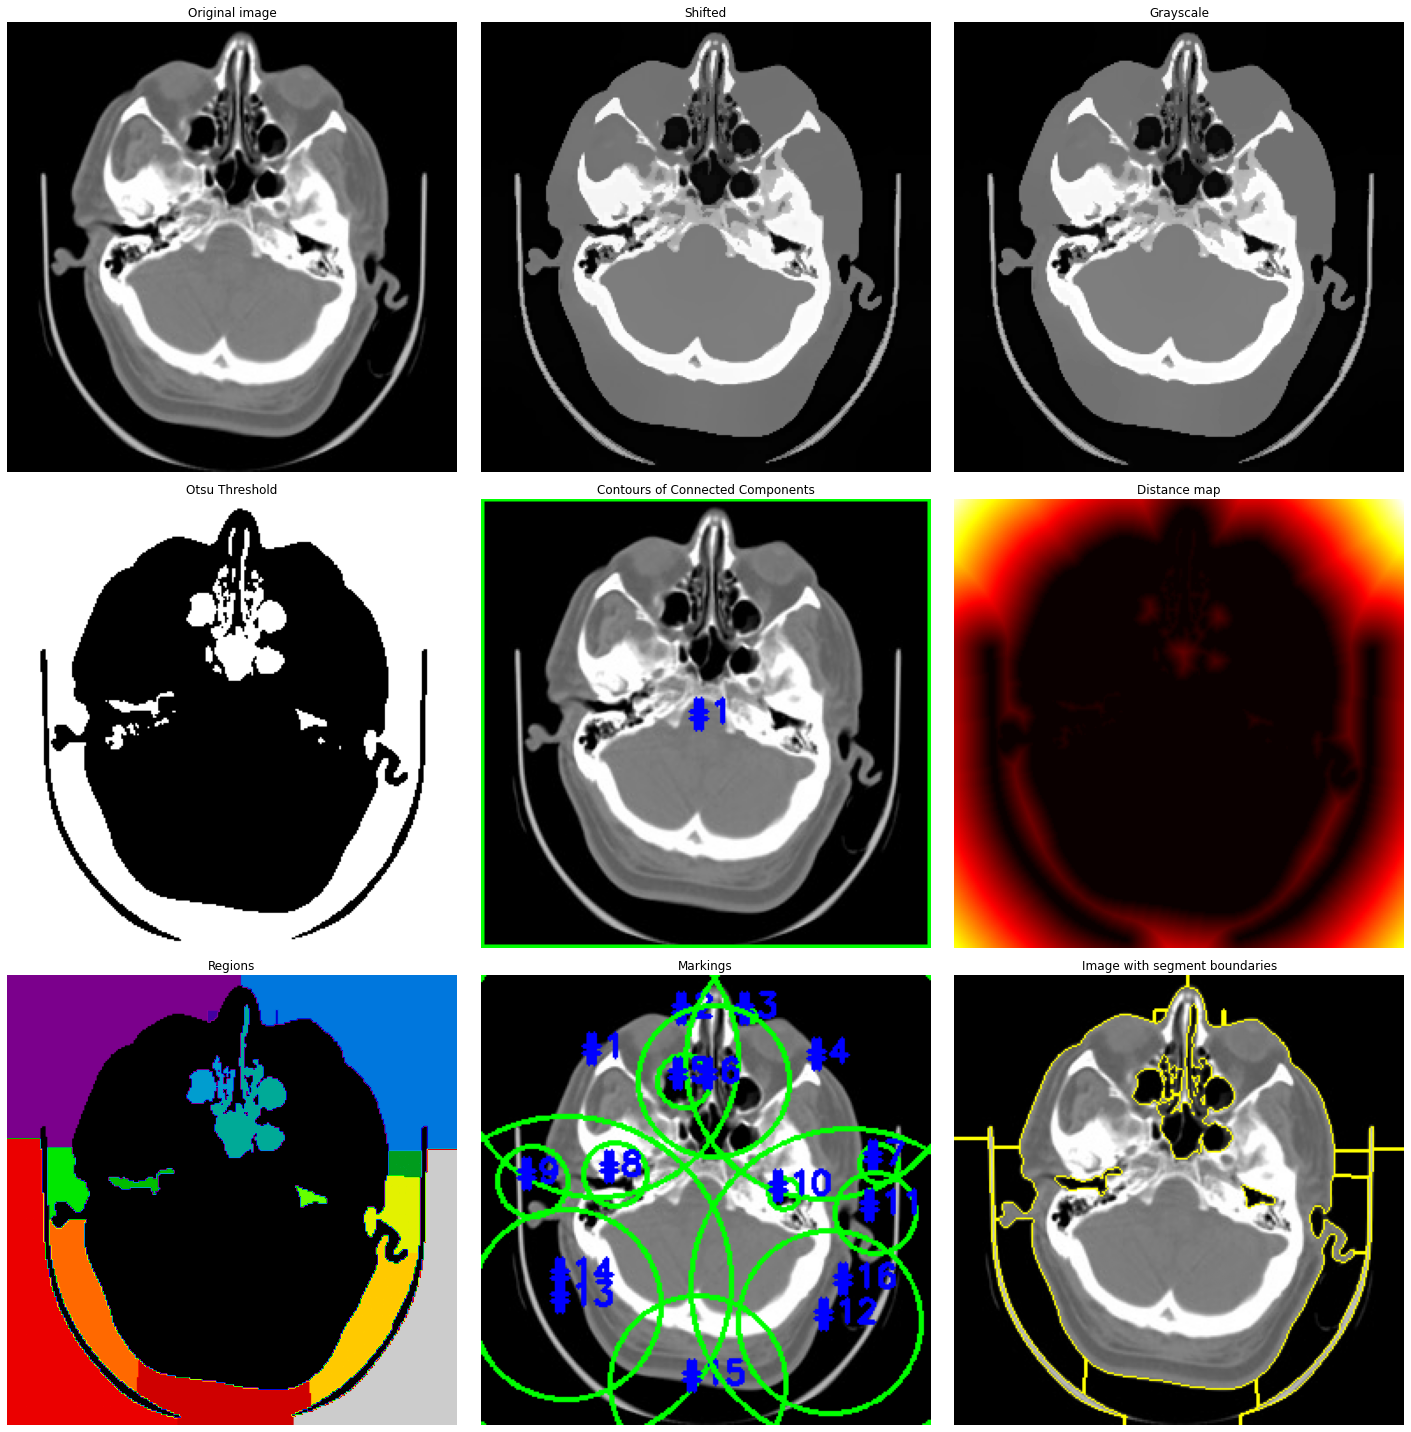

In [ ]:
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
import cv2
import imutils
import copy

# carrega a imagem e execute a filtragem de deslocamento médio da pirâmide
# para ajudar na etapa de limiarização
#image = cv2.imread("/content/dataSeg/coins-01.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

shifted = cv2.pyrMeanShiftFiltering(image, 21, 51)

# converta a imagem de deslocamento médio em escala de cinza e aplique
# Limiar de Otsu
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
# Como neste caso o fundo é mais claro que as moedas, você terá que inverter a imagem do limite
thresh = cv2.bitwise_not(thresh)

# encontrar contornos na imagem com limite
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
print("[INFO] {} unique contours found".format(len(cnts)))

contours = copy.deepcopy(image)
# percorrer os contornos
for (i, c) in enumerate(cnts):
    # desenhe o contorno
    ((x, y), _) = cv2.minEnclosingCircle(c)
    cv2.putText(contours, "#{}".format(i + 1), (int(x) - 10, int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    cv2.drawContours(contours, [c], -1, (0, 255, 0), 2)

# Pré-cálculos Watershed
# calcule a distância euclidiana exata de cada pixel binário até o pixel zero mais próximo e, em seguida, encontre picos neste mapa de distância
D = ndimage.distance_transform_edt(thresh)
localMax = peak_local_max(D, indices=False, min_distance=20, labels=thresh)

# realizar uma análise de componentes conectados nos picos locais, usando conectividade 8 e, em seguida, aplicar o algoritmo Watershed
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
# finalmente chame a função Watershed!
labels = watershed(-D, markers, mask=thresh)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

# faça um loop sobre os rótulos exclusivos retornados pelo algoritmo Watershed
water = copy.deepcopy(image)
for label in np.unique(labels):
    # se o rótulo for zero, estamos examinando o 'plano de fundo'
    # então simplesmente ignore
    if label == 0:
        continue

    # caso contrário, aloque memória para a região do rótulo e desenhe
    # na máscara
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255

    # detecte contornos na máscara e pegue o maior
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # desenhe um círculo envolvendo o objeto
    ((x, y), r) = cv2.minEnclosingCircle(c)
    cv2.circle(water, (int(x), int(y)), int(r), (0, 255, 0), 2)
    cv2.putText(water, "#{}".format(label), (int(x) - 10, int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)


fig, axes = plt.subplots(nrows = 3,ncols=3, figsize=(20, 20), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Imagem original')

ax[1].imshow(shifted, cmap=plt.cm.gray)
ax[1].set_title('Deslocado')

ax[2].imshow(gray, cmap=plt.cm.gray)
ax[2].set_title('Tons de cinza')

ax[3].imshow(thresh, cmap=plt.cm.gray)
ax[3].set_title('Otsu Threshold')

ax[4].imshow(contours)
ax[4].set_title('Contornos de componentes conectados')

ax[5].imshow(D, cmap=plt.cm.hot)
ax[5].set_title('Distance map')

ax[6].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[6].set_title('Regiões')

ax[7].imshow(water, cmap=plt.cm.nipy_spectral)
ax[7].set_title('Marcações')

ax[8].imshow(mark_boundaries(image, labels), cmap=plt.cm.gray)
ax[8].set_title('Imagem com limites de segmento')



for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()


## Métodos Variacionais: Mumford & Shah Funcional

Em vez do M&S original, usaremos o *Ambrosio Tortorelli Minimizer variant* implementado por Jacob Gildenblat (jacob.gildenblat@gmail.com). Para simplificar, chamaremos isso de **A&Tmin** neste colab. O blog do Jacob está aqui: https://jacobgil.github.io/

### Importe itens necessários para escala de cinza e cores

Processaremos as imagens de maneira diferente dependendo se elas são coloridas ou não, mas isso aqui você vai precisar de qualquer maneira.

In [ ]:
# Faça isso uma vez (ou sempre que reiniciar o kernel se estiver usando o Colab)
# O código abaixo baixa a versão armazenada no meu espelho
# parâmetros wget:
# --backups=1 : renomeia o arquivo original com o sufixo .1 e grava o novo arquivo no nome de arquivo pretendido
# -q : run quiet unless there's an error
!wget --backups=1 -q https://raw.githubusercontent.com/awangenh/Ambrosio-Tortorelli-Minimizer/master/AmbrosioTortorelliMinimizer.py

In [ ]:
from ipywidgets import interact, interactive, interact_manual
import cv2, scipy
from skimage import data
from matplotlib import pyplot as plt
# Importe o M&S-equivalent Ambrosio Tortorelli Minimizer (vamos chamá-lo de A&Tmin)
# Você tem que baixá-lo antes de https://github.com/jacobgil/Ambrosio-Tortorelli-Minimizer
from AmbrosioTortorelliMinimizer import *

### A&Tmin for Grayscale Images

In [ ]:
# image = cv2.imread("/content/dataSeg/ct-01.jpg", cv2.IMREAD_GRAYSCALE)
image = cv2.imread("/content/dataSeg/ct-02.jpg", cv2.IMREAD_GRAYSCALE)

def my_ATmin(iterations, solver_maxiterations, tol, alpha, beta, epsilon, colormap):
    global image
    colormap = eval('plt.cm.' + colormap)
    solver = AmbrosioTortorelliMinimizer(image, iterations, solver_maxiterations, tol, alpha, beta, epsilon)
    seg, edges = solver.minimize()

    fig, axes = plt.subplots(ncols=3, figsize=(20, 7), sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('Imagem original')

    ax[1].imshow(edges, cmap=plt.cm.gray)
    ax[1].set_title('Arestas')

    ax[2].imshow(seg, cmap=colormap)
    ax[2].set_title('Resultado')

    for a in ax:
        a.axis('off')

    fig.tight_layout()
    plt.show()

interact_manual(my_ATmin, iterations = (1, 100, 1), solver_maxiterations = (1, 100), tol = (0.01, 1.0), alpha = (100, 10000, 100),
                beta = (0.001, 0.1, 0.001), epsilon = (0.001, 0.1, 0.001), colormap = ['nipy_spectral', 'hot', 'magma', 'seismic'])
# Valores padrões: iterations = 1, solver_maxiterations = 10, tol = 0.1, alpha = 1000, beta = 0.01, epsilon = 0.01

interactive(children=(IntSlider(value=50, description='iterations', min=1), IntSlider(value=50, description='s…

<function __main__.my_ATmin(iterations, solver_maxiterations, tol, alpha, beta, epsilon, colormap)>

### A&Tmin para imagens coloridas

A implementação de Jacob Gildenblat é uma implementação de canal único. Não é realmente adequado para imagens coloridas, mas podemos, como o próprio autor demonstra, usá-lo para imagens coloridas empregando o truque sujo de processar os canais de cores de forma independente e depois usar uma abordagem máxima para as bordas:

In [ ]:
image = cv2.imread("/content/dataSeg/car-01.jpg", cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def my_ColorATmin(iterations, solver_maxiterations, tol, alpha, beta, epsilon):
    global image
    # Crie listas vazias para os resultados parciais
    seg, edges = [], []
    # Dividir imagem por canais (R, G, B)
    for channel in cv2.split(image):
        solver = AmbrosioTortorelliMinimizer(channel, iterations, solver_maxiterations, tol, alpha, beta, epsilon)
        channel_seg, channel_edges = solver.minimize()
        # Anexar resultado do canal à lista
        seg.append(channel_seg)
        edges.append(channel_edges)

    # Mesclar canais em uma imagem segmentada de 3 canais
    segments = cv2.merge(seg)
    # Considere o máximo de cada canal como o pixel da borda
    edges = np.maximum(*edges)

    fig, axes = plt.subplots(ncols=3, figsize=(20,8))
    ax = axes.ravel()

    ax[0].imshow(image)
    ax[0].set_title('Original image')

    ax[1].imshow(segments)
    ax[1].set_title('Result')

    ax[2].imshow(edges, cmap=plt.cm.gray)
    ax[2].set_title('Edges')

    for a in ax:
        a.axis('off')

    plt.tight_layout()
    plt.show()

# Valores padrão: iterations = 1, solver_maxiterations = 10, tol = 0.1, alpha = 1000, beta = 0.01, epsilon = 0.01
interact_manual(my_ColorATmin, iterations = (1, 100, 1), solver_maxiterations = (1, 100), tol = (0.01, 1.0), alpha = (100, 10000, 100),
                beta = (0.001, 0.1, 0.001), epsilon = (0.001, 0.1, 0.001))
None

interactive(children=(IntSlider(value=50, description='iterations', min=1), IntSlider(value=50, description='s…

# Créditos

* A seção Watershed foi parcialmente baseada em material disponível em:
  * https://www.pyimagesearch.com/2015/11/02/watershed-opencv/
  * https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_watershed.html
  * https://docs.opencv.org/3.4.3/d3/db4/tutorial_py_watershed.html
* A seção Mumford & Shah foi parcialmente baseada em material disponível em:
  * A excelente e inovadora implementação Python da variante Ambrosio-Tortorelli-Minimizer do M&S em: https://github.com/jacobgil/Ambrosio-Tortorelli-Minimizer
  * A documentação da variante Ambrosio-Tortorelli-Minimizer do M&S em: https://jacobgil.github.io/computervision/mumford-shah and http://jacobcv.blogspot.com/2015/04/smoothing-images-with-mumford-shah.html
* Truques gerais para exibir imagens vieram daqui: https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_gui/py_image_display/py_image_display.html
* Também usamos algumas dicas gerais de: https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html#sphx-glr-auto-examples-segmentation-plot-segmentations-py
* Também usamos material do Professor Aldo von Wangenheim da UFSC